# Import

In [1]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import cv2

import random
from tqdm import tqdm

import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

from keras.applications import MobileNetV2

from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


# def

In [2]:
# text ("1"), title ("2"), list ("3"), table ("4"), figure ("5")

Kat = {
    "1": "text",
    "2": "title",
    "3": "list",
    "4": "table",
    "5": "figure"
}

# Darknet

## laden vom Darknet

In [3]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

Cloning into 'darknet'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 13785 (delta 0), reused 0 (delta 0), pack-reused 13784
Receiving objects: 100% (13785/13785), 12.35 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (9407/9407), done.
/content/darknet


In [4]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_res’ [-W

# Vorbereitung
Wir brauchen:
- Ein gelabeltes Datenset (Danke IBM)
- .cfg File
- obj.data und obj.names
- train.txt file (optional)

## Funktionen

In [6]:
def WriteToFile(Name, InhaltInArrayForm):
  file = open(Name, 'w')
  for i in InhaltInArrayForm:
    file.write(i)
    file.write("\n")
  file.close()

In [7]:
def openTar(Name):
  tar = tarfile.open(Name)
  tar.extractall()
  tar.close()
  print(Name + " entpacked")

## Daten Laden


In [8]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz --output "labels.tar.gz"
openTar("labels.tar.gz")
!rm labels.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  80.7M      0  0:00:03  0:00:03 --:--:-- 80.7M
labels.tar.gz entpacked


In [9]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/val.tar.gz --output "val.tar.gz"
openTar("val.tar.gz")
!rm val.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3106M  100 3106M    0     0  38.4M      0  0:01:20  0:01:20 --:--:-- 39.4M
val.tar.gz entpacked


## Transformieren



In [10]:
StringToJson = 'publaynet/val.json'
StringToFolder = 'publaynet/val/'

Labels = []

with open(StringToJson, 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in tqdm(samples['images']):
    images[image['id']] = {'file_name': image['file_name'], 'annotations': []}
for ann in tqdm(samples['annotations']):
    images[ann['image_id']]['annotations'].append(ann)

100%|██████████| 120761/120761 [00:00<00:00, 1956129.15it/s]


In [11]:
def convert_labels(path, b0, b1, b2, b3):

    x1 = b0
    y1 = b1
    x2 = b0 + b2
    y2 = b1 + b3
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return x,y,w,h


def get_img_shape(path):
    path = path
    img = cv2.imread(path)
    try:
        return img.shape
    except AttributeError:
        print('error! ', path)
        return (None, None, None)

In [12]:
!mkdir data/train

InhaltFürTrain = []
PathToTrain = 'data/train.txt'

XGröße = 600
YGröße = 792

last = ""

for i, (_, image) in tqdm(enumerate(images.items())):
  FileName = image['file_name']
  last = FileName.split(".")[0]

  SpeicherUnter = 'data/train/'

  file = Image.open(StringToFolder + FileName)
  file.save(SpeicherUnter + FileName)

  DataFileName = SpeicherUnter + FileName.split('.')[0] + '.txt'

  Inhalt = []
  
  annotations = image['annotations']
  for pictures in annotations:
    Box = pictures['bbox']
    Category = int(pictures['category_id']) - 1
    #x
    x,w,y,h = convert_labels(StringToFolder + FileName, Box[0], Box[1], Box[2], Box[3])

    TempString = str(Category)
    TempString += " " + str(x)
    TempString += " " + str(w)
    TempString += " " + str(y)
    TempString += " " + str(h)

    Inhalt.append(TempString)
    # print(FileName + "     " + TempString)
    
  InhaltFürTrain.append('data/train/' + FileName)
  WriteToFile(DataFileName, Inhalt)

WriteToFile(PathToTrain, InhaltFürTrain)

11245it [18:30, 10.13it/s]


### obj.names
enthält alle Labels, eins pro Zeile

In [13]:
Name = 'obj.names'
Zusatz = 'data/'
FileName = Zusatz + Name
Inhalt = []

for i in range(1,6):
  Inhalt.append(Kat[str(i)])

WriteToFile(FileName, Inhalt)

### obj.data

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

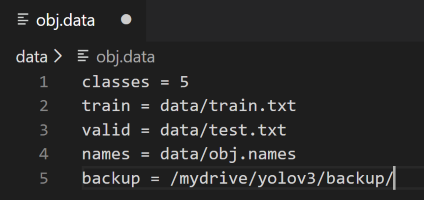



In [14]:
!mkdir ../backup

Inhalt = [
          'classes = 5',
          'train = data/train.txt',
          'names = data/obj.names',
          'backup = ../backup'
]
PathToObjData = 'data/obj.data'

WriteToFile(PathToObjData, Inhalt)


### Zusatz

Extra Weights für das Netz um es einfacher zu machen

In [15]:
# !wget http://pjreddie.com/media/files/darknet53.conv.74

# Training

In [16]:
%cd darknet/

[Errno 20] Not a directory: 'darknet/'
/content/darknet


In [17]:
# !./darknet detector train data/obj.data ../drive/My\ Drive/data/yolov3_custom.cfg ../drive/My\ Drive/data/darknet53.conv.74 -dont_show

# Falls es zwischendurch abstürzt:
!./darknet detector train data/obj.data ../drive/My\ Drive/data/yolov3_custom.cfg ../drive/My\ Drive/backup/yolov3_custom_4000.weights -dont_show

Streaming output truncated to the last 5000 lines.
 total_bbox = 3740228, rewritten_bbox = 0.119779 % 

 9926: 0.360893, 0.410505 avg loss, 0.000010 rate, 6.053894 seconds, 635264 images, 0.192923 hours left
Loaded: 0.000043 seconds
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.895810, GIOU: 0.894372), Class: 0.998978, Obj: 0.956262, No Obj: 0.007395, .5R: 1.000000, .75R: 0.928571, count: 14, class_loss = 0.046079, iou_loss = 0.193962, total_loss = 0.240041 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 94 Avg (IOU: 0.882363, GIOU: 0.880909), Class: 0.996384, Obj: 0.967713, No Obj: 0.000411, .5R: 1.000000, .75R: 1.000000, count: 6, class_loss = 0.072548, iou_loss = 0.042719, total_loss = 0.115268 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.954033, GIOU: 0.954032), Class: 0.999905, Obj: 0.992128, No Obj: 0.000021, .5R: 1.000000, .75R: 1.000000, count: 1, class_loss = 0.003265, iou_loss = 0.001198, total_loss = 0.004463 
 to

# Ausgabe des Ergebnis


## Vorbereitung 

In [18]:
!ls

3rdparty		 darknet		 Makefile
backup			 DarknetConfig.cmake.in  net_cam_v3.sh
build			 darknet.py		 obj
build.ps1		 darknet_video.py	 publaynet
build.sh		 data			 README.md
cfg			 image_yolov2.sh	 results
chart.png		 image_yolov3.sh	 scripts
chart_yolov3_custom.png  include		 src
cmake			 json_mjpeg_streams.sh	 video_v2.sh
CMakeLists.txt		 LICENSE		 video_yolov3.sh


In [19]:
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
sed: can't read yolov3_custom.cfg: No such file or directory
sed: can't read yolov3_custom.cfg: No such file or directory
/content/darknet


## Test

Vorher noch ein Bild hochladen

In [20]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/examples.tar.gz --output "examples.tar.gz"
openTar("examples.tar.gz")
!rm examples.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6309k  100 6309k    0     0  5501k      0  0:00:01  0:00:01 --:--:-- 5510k
examples.tar.gz entpacked


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 

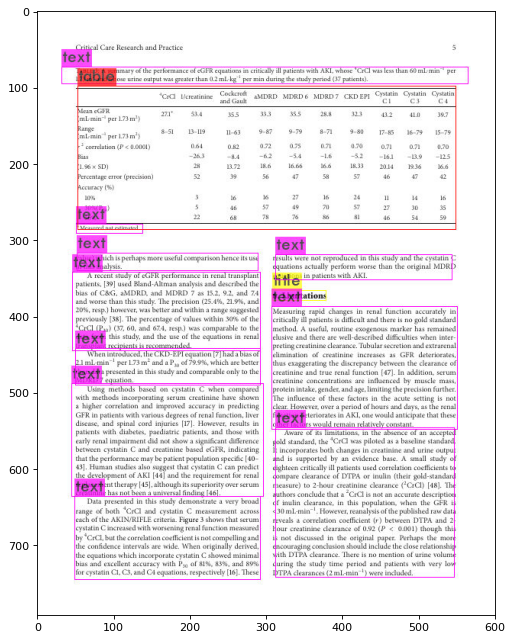

In [23]:
!./darknet detector test data/obj.data ../drive/My\ Drive/data/yolov3_custom.cfg ../drive/My\ Drive/backup/yolov3_custom_final.weights examples/PMC3576793_00004.jpg -thresh 0.3
Ergebnis = Image.open('predictions.jpg')

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(Ergebnis)

## Testen der Umwandlung

In [ ]:
# %cd darknet

StringToJson = 'examples/samples.json'
StringToFolder = 'examples/'

Labels = []

with open(StringToJson, 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in tqdm(samples['images']):
    images[image['id']] = {'file_name': image['file_name'], 'annotations': []}
for ann in tqdm(samples['annotations']):
    images[ann['image_id']]['annotations'].append(ann)

In [ ]:
!mkdir examples/train

XGröße = 600
YGröße = 792

for i, (_, image) in tqdm(enumerate(images.items())):
  FileName = image['file_name']

  SpeicherUnter = 'examples/train/'

  file = Image.open(StringToFolder + FileName)
  file.save(SpeicherUnter + FileName)

  DataFileName = SpeicherUnter + FileName.split('.')[0] + '.txt'

  Inhalt = []
  
  annotations = image['annotations']
  for pictures in annotations:
    Box = pictures['bbox']
    Category = int(pictures['category_id']) - 1
    #x
    x,w,y,h = convert_labels(StringToFolder + FileName, Box[0], Box[1], Box[2], Box[3])

    TempString = str(Category)
    TempString += " " + str(x)
    TempString += " " + str(w)
    TempString += " " + str(y)
    TempString += " " + str(h)

    Inhalt.append(TempString)
    # print(FileName + "     " + TempString)
    
  WriteToFile(DataFileName, Inhalt)

WriteToFile(PathToTrain, InhaltFürTrain)

In [ ]:
def from_yolo_to_cor(box, shape):
  img_h = shape[0]
  img_w = shape[1]

  # x1, y1 = ((x + witdth)/2)*img_width, ((y + height)/2)*img_height
  # x2, y2 = ((x - witdth)/2)*img_width, ((y - height)/2)*img_height
  b0 = float(box[0])
  b1 = float(box[1])
  b2 = float(box[2])
  b3 = float(box[3])

  x1, y1 = int((b0 + b2/2)*img_w), int((b1 + b3/2)*img_h)
  x2, y2 = int((b0 - b2/2)*img_w), int((b1 - b3/2)*img_h)
  return x1, y1, x2, y2


pathToText = "examples/train/PMC3576793_00004.txt"
pathToImage = "examples/train/PMC3576793_00004.jpg"

Bild = cv2.imread(pathToImage)

Shape = (792, 601, 3)
Lines = open(pathToText).readlines()

for i in Lines:
  Line = i.split("\n")[0]
  Line = Line.split(" ")
  boxes = Line[1:]

  x1, y1, x2, y2 = from_yolo_to_cor(boxes, Shape)
  
  cv2.rectangle(Bild, (x1, y1), (x2, y2), (0,255,0), 3)


plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(Bild)